In [1]:
!pip install arch yfinance > log.txt

In [342]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from statsmodels.stats.diagnostic import acorr_ljungbox

import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [343]:
def get_hourly_data(name='BTC', start='2023-10-01', end='2024-10-01'):
    data = yf.download(f'{name}-USD', start=start, end=end, interval='1h')
    #data['Returns'] = 100 * data['Adj Close'].pct_change().dropna()
    data['Adj Close'] /= np.mean(data['Adj Close'])
    data['Log Returns'] = (np.log(data['Adj Close'])).diff()
    return data

def generate_HAR_data(data, w_len=7, m_len=30):
    """
    Функция для генерации нужных лагов для HAR модели из данных data.
    """
    new_data = data.copy()
    volatility = new_data['Log Returns'].resample('D').std()
    daily_returns = new_data['Log Returns'].resample('D').mean()

    rv_data = pd.DataFrame({
        'Datetime': pd.to_datetime(volatility.index),
        'rv': volatility.values,
        'daily returns': daily_returns.values
    })

    rv_data['rv w'] = rv_data['rv'].rolling(window=w_len).mean()
    rv_data['rv m'] = rv_data['rv'].rolling(window=m_len).mean()

    return rv_data

def generate_HARQ_data(data, w_len=7, m_len=30):
    """
    Функция для генерации нужных лагов для HAR модели из данных data.
    """
    new_data = data.copy()
    volatility = new_data['Log Returns'].resample('D').std()
    rq = new_data['Log Returns'].resample('D').apply(lambda x: np.sum(x**4)/123) # hours / 3
    daily_returns = new_data['Log Returns'].resample('D').mean()

    rv_data = pd.DataFrame({
        'Datetime': pd.to_datetime(rq.index),
        'rv': volatility.values,
        'rq': rq.values,
        'daily returns': daily_returns.values
    })

    rv_data['rv w'] = rv_data['rv'].rolling(window=w_len).mean()
    rv_data['rv m'] = rv_data['rv'].rolling(window=m_len).mean()

    rv_data['rq w'] = rv_data['rq'].rolling(window=w_len).mean()
    rv_data['rq m'] = rv_data['rq'].rolling(window=m_len).mean()

    return rv_data

In [344]:
class HAR:
  def __init__(self, name='HAR'):
    self.name = name

  def __fit_har(self, data):
    X = pd.DataFrame({
      'RV': data['rv'][:-1],
      'RV_w': data['rv w'][:-1],
      'RV_m': data['rv m'][:-1]
    })
    self.X = X

  def __fit_harq(self, data):
    X = pd.DataFrame({
      'RV': data['rv'][:-1],
      'RV_w': data['rv w'][:-1],
      'RV_m': data['rv w'][:-1],
      'RQ': np.sqrt(data['rq'][:-1]) * data['rv'][:-1],
      'RQ_w': np.sqrt(data['rq w'][:-1]) * data['rv w'][:-1],
      'RQ_m': np.sqrt(data['rq m'][:-1]) * data['rv m'][:-1],
    })
    self.X = X

  def fit(self, data):
    if self.name == 'HAR':
        self.__fit_har(data)
    elif self.name == 'HARQ':
        self.__fit_harq(data)
        
    X = self.X.reset_index(drop=True)
    X = sm.add_constant(X)
    y = data['rv'][1:]
    y = y.reset_index(drop=True)
    model = sm.OLS(y, X).fit()
    self.model = model

  def predict(self, data):

    last_row = 0
    if self.name == 'HAR':
      last_row = data[['rv', 'rv w', 'rv m']].iloc[-1]
    elif self.name == 'HARQ':
      last_row = data[['rv', 'rv w', 'rv m', 'rq', 'rq w', 'rq m']].iloc[-1]

    last_row_with_const = [1] + last_row.tolist()
    last_row_with_const = np.array(last_row_with_const).reshape(1, -1)
    predictions = self.model.predict(last_row_with_const)

    return predictions

def get_rolling_har_predictions(data, model_name='HAR', window_size=100):
    vol_forecast = []

    for i in range(window_size, len(data)):
        window_data = data[i - window_size : i]
        model = HAR(name=model_name)
        model.fit(window_data)
        vol_forecast.append(model.predict(window_data))

    return np.array(vol_forecast).flatten()

def get_naive_predictions(data, window=100):
    return np.array(data['rv'][window:]).flatten()

In [345]:
name = 'ETH'

hourly_data = get_hourly_data(name=name)


#hourly_data['Log Returns'] /= np.abs(hourly_data['Log Returns'])**0.5

# k = np.abs(hourly_data['Log Returns']).mean()
# hourly_data['Log Returns'] /= k

# print(hourly_data['Log Returns'].mean())

har_data = generate_HAR_data(hourly_data)
har_data = har_data.dropna()


hourly_data.head(5)

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Log Returns
Ticker,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD,
Datetime,,,,,,,
2023-10-01 00:00:00+00:00,0.606439,1674.245728,1674.692139,1670.948242,1671.161499,0,NaN
2023-10-01 01:00:00+00:00,0.606626,1674.763672,1676.785522,1673.050537,1674.294678,0,0.000309
2023-10-01 02:00:00+00:00,0.606246,1673.714600,1674.769897,1672.531616,1674.252563,15463424,-0.000627
2023-10-01 03:00:00+00:00,0.606440,1674.250488,1674.298218,1672.675903,1673.684448,451328,0.000320
2023-10-01 04:00:00+00:00,0.606839,1675.351929,1675.582764,1673.582886,1674.323608,11805184,0.000658


<Axes: >

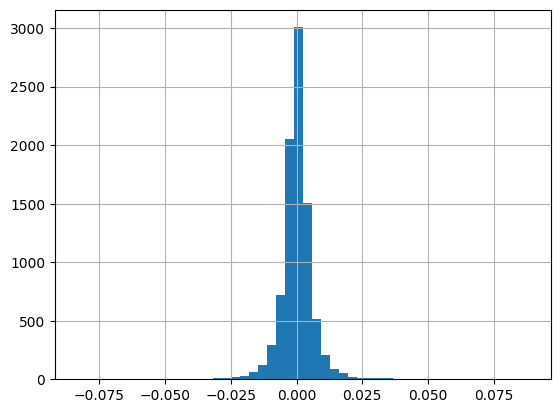

In [346]:
hourly_data['Log Returns'].hist(bins=50)

In [347]:
har_predictions = get_rolling_har_predictions(har_data, model_name='HAR')
naive_predictions = get_naive_predictions(har_data)

In [348]:
def cut_data(data, predictions):
  """
  Функция обрезает данных из даты и predictions по одинаквым периодам, что бы можно было построить график или посчитать метрики
  """
  cut_predictions = predictions[:-1]
  predictions_size = len(cut_predictions)
  cut_realize_volatility = data['rv'][-predictions_size:]
  cut_datetime_axes = data['Datetime'][-predictions_size:]
  return cut_predictions, cut_realize_volatility, cut_datetime_axes

def plot_predictions(data, predictions):
  cut_predictions, cut_realize_volatility, cut_datetime_axes = cut_data(data, predictions)

  plt.figure(figsize=(12, 6))

  plt.plot(cut_datetime_axes, cut_realize_volatility, label='Realized Volatility', color='blue')
  plt.plot(cut_datetime_axes, cut_predictions, label='Predicted Volatility', color='red')
  plt.title('Predicted vs. Realized Volatility')
  plt.xlabel('Date')
  plt.ylabel('Volatility (%)')
  plt.legend()
  plt.grid()
  plt.show()

def calculate_metrics(data, predictions):
    cut_predictions, cut_realize_volatility, _ = cut_data(data, predictions)
    
    # MSE (Mean Squared Error)
    mse = np.mean((cut_realize_volatility - cut_predictions)**2)
    
    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(cut_realize_volatility - cut_predictions))

    n = len(cut_predictions)

    cut_realize_volatility = list(cut_realize_volatility)
    cut_predictions = list(cut_predictions)

    directional_accuracy = 0
    for i in range(1, n):
        if (cut_realize_volatility[i] - cut_realize_volatility[i - 1]) * (cut_predictions[i] - cut_realize_volatility[i - 1]) > 0:
            directional_accuracy += 1
            
    directional_accuracy /= (n-1)
    
    return {
        'MSE': mse,
        'MAE': mae,
        'Directional Accuracy': directional_accuracy
    }

In [350]:
print(calculate_metrics(har_data, har_predictions))
print(calculate_metrics(har_data, naive_predictions))

{'MSE': 1.1849695069154969e-05, 'MAE': 0.002258658472443791, 'Directional Accuracy': 0.6808510638297872}
{'MSE': 1.3991033588932209e-05, 'MAE': 0.002592667888418797, 'Directional Accuracy': 0.0}


# HARQ

In [351]:
harq_data = generate_HARQ_data(hourly_data)
harq_data = harq_data.dropna()
harq_data.head(5)

,Datetime,rv,rq,daily returns,rv w,rv m,rq w,rq m
29,2023-10-30 00:00:00+00:00,0.004832,9.454674e-10,0.000347,0.005087,0.003988,1.531181e-09,1.267759e-09
30,2023-10-31 00:00:00+00:00,0.003538,5.181008e-11,0.000150,0.004303,0.003873,4.350222e-10,9.731909e-10
31,2023-11-01 00:00:00+00:00,0.004609,2.320215e-10,0.000680,0.004281,0.003829,4.214549e-10,9.355562e-10
32,2023-11-02 00:00:00+00:00,0.003388,7.869156e-11,-0.001051,0.003730,0.003858,2.362757e-10,9.372350e-10
33,2023-11-03 00:00:00+00:00,0.003984,1.233297e-10,0.000735,0.003593,0.003893,2.101009e-10,9.369186e-10


In [352]:
harq_predictions = get_rolling_har_predictions(harq_data, model_name='HARQ')

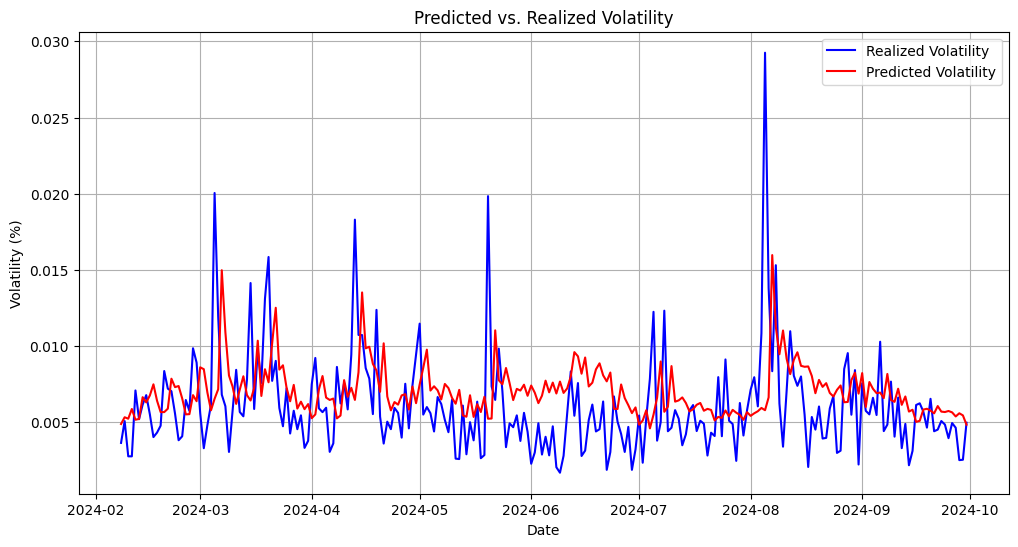

In [353]:
plot_predictions(harq_data, harq_predictions)

In [354]:
print(calculate_metrics(harq_data, harq_predictions))
print(calculate_metrics(har_data, naive_predictions))

{'MSE': 1.3348248022186168e-05, 'MAE': 0.002646530557453155, 'Directional Accuracy': 0.6425531914893617}
{'MSE': 1.3991033588932209e-05, 'MAE': 0.002592667888418797, 'Directional Accuracy': 0.0}


# GARCH

In [355]:
def get_rolling_garch_predictions(returns, model_params, window_size=100):
    vol_forecast = []
    for i in range(window_size, len(returns)):
        window_data = returns[i-window_size:i]
        model = arch_model(window_data, **model_params)
        garch_fit = model.fit(disp="off", options={'maxiter': 350})
        # Forecast one-step ahead volatility
        vol_forecast.append(garch_fit.forecast(horizon=1).variance.values[-1, :][0])

    # Align the forecast with the returns data
    vol_forecast = pd.Series(vol_forecast, index=returns.index[window_size:])
    # return vol_forecast
    return np.sqrt(vol_forecast) * np.sqrt(24)

In [356]:
model_params = {'vol': 'garch', 'q': 1, 'p': 1, 'o': 1}
garch_predictions = get_rolling_garch_predictions(har_data['daily returns']*1000, model_params)

/opt/conda/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [414]:
print(calculate_metrics(har_data, naive_predictions))

print(calculate_metrics(har_data, garch_predictions/1000))
print(calculate_metrics(har_data, har_predictions))
print(calculate_metrics(har_data, harq_predictions))


v = [0.3, 0.3, 0.3]
ens_predictions = (v[0] * naive_predictions + v[1] * garch_predictions.values / 1000 + v[2] * har_predictions) / sum(v)

print(calculate_metrics(har_data, ( 0.5 * garch_predictions.values / 1000 + 0.49 * har_predictions + 0.01 * harq_predictions)))
print(calculate_metrics(har_data, ens_predictions))

{'MSE': 1.3991033588932209e-05, 'MAE': 0.002592667888418797, 'Directional Accuracy': 0.0}
{'MSE': 1.393518504554432e-05, 'MAE': 0.00250992828269327, 'Directional Accuracy': 0.6382978723404256}
{'MSE': 1.1849695069154969e-05, 'MAE': 0.002258658472443791, 'Directional Accuracy': 0.6808510638297872}
{'MSE': 1.3348248022186168e-05, 'MAE': 0.002646530557453155, 'Directional Accuracy': 0.6425531914893617}
{'MSE': 1.3909714209529818e-05, 'MAE': 0.0025480053120666615, 'Directional Accuracy': 0.6382978723404256}
{'MSE': 1.1686220949171344e-05, 'MAE': 0.0023299607898818278, 'Directional Accuracy': 0.6382978723404256}


In [415]:
def ljung_test(residuals):
    sm.graphics.tsa.plot_acf(residuals, lags=20, title="ACF of Residuals")
    sm.graphics.tsa.plot_pacf(residuals, lags=20, title="PACF of Residuals")

    ljung_box_results = acorr_ljungbox(residuals, lags=[1, 2, 3, 4, 5], return_df=True)
    print(ljung_box_results)

In [416]:
naive_a,naive_b,naive_c=cut_data(har_data, naive_predictions)
har_a,har_b,har_c=cut_data(har_data, har_predictions)
garch_a,garch_b,garch_c=cut_data(har_data, garch_predictions.values / 1000)
ens_a,ens_b,ens_c=cut_data(har_data, ens_predictions)

naive_residuals = naive_a - naive_b
har_residuals = har_a - har_b
garch_residuals = garch_a - garch_b
ens_residuals = ens_a - ens_b

     lb_stat     lb_pvalue
1  30.295891  3.709108e-08
2  38.908743  3.556918e-09
3  43.683864  1.761534e-09
4  44.360560  5.399399e-09
5  45.415906  1.194131e-08


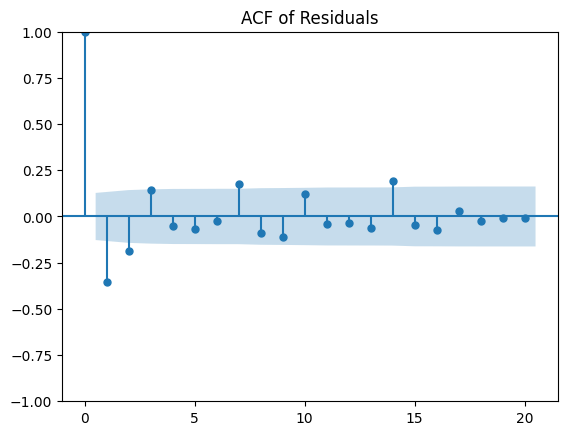

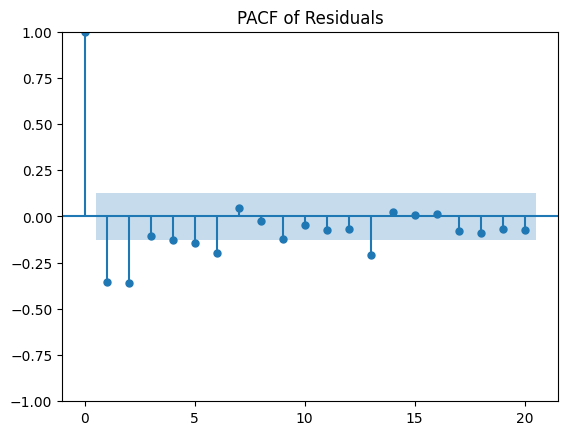

In [417]:
ljung_test(naive_residuals)

     lb_stat  lb_pvalue
1  14.026194   0.000180
2  20.610972   0.000033
3  22.275632   0.000057
4  22.282897   0.000176
5  23.814120   0.000236


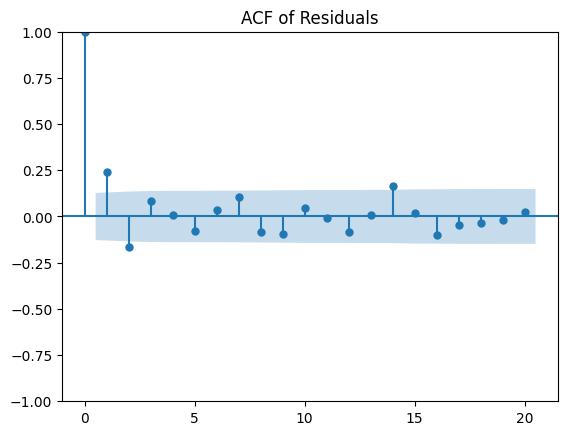

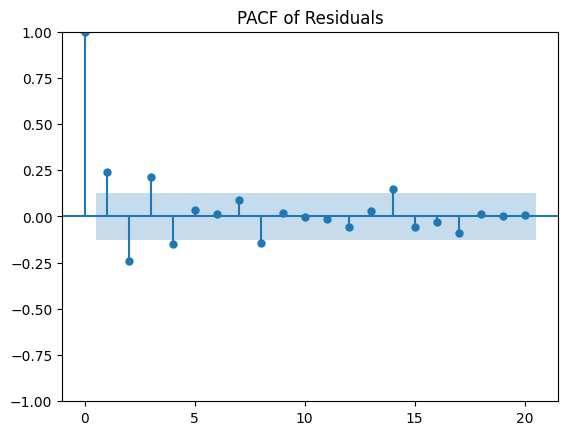

In [418]:
ljung_test(har_residuals)

     lb_stat  lb_pvalue
1   0.018815   0.890899
2   1.449706   0.484396
3  16.037705   0.001114
4  16.259164   0.002690
5  16.395005   0.005802


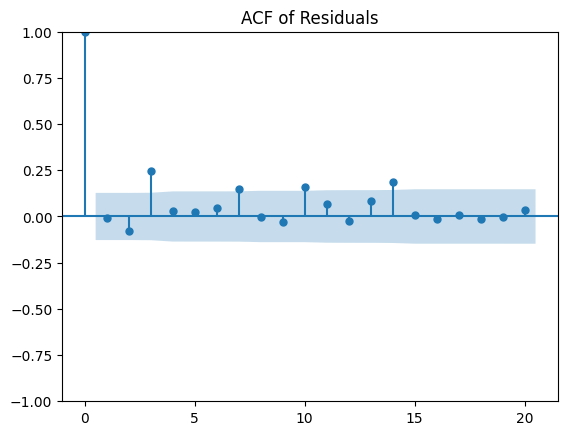

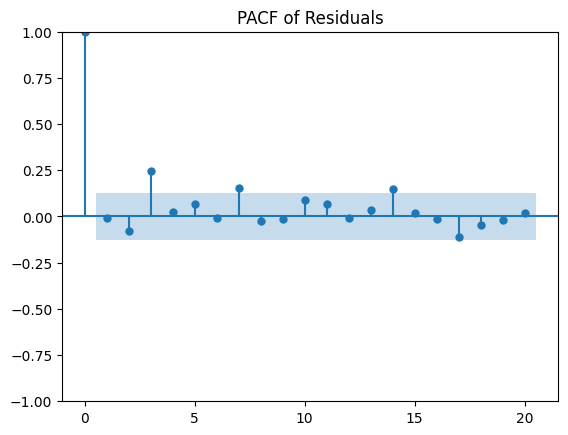

In [419]:
ljung_test(garch_residuals.dropna())

     lb_stat  lb_pvalue
1   6.022060   0.014128
2  16.154324   0.000311
3  21.631534   0.000078
4  21.809048   0.000219
5  22.549717   0.000411


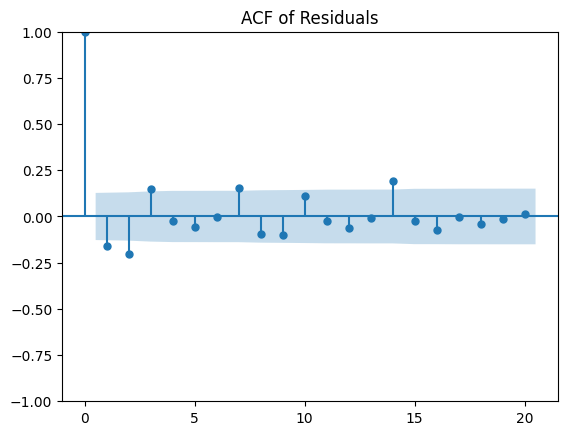

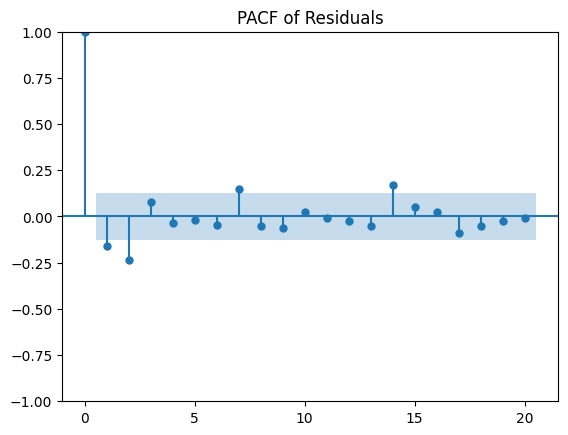

In [420]:
ljung_test(ens_residuals)

In [381]:
garch_residuals.dropna()

130    0.002157
131    0.000736
132    0.003051
133    0.003067
134   -0.002178
         ...   
361   -0.000003
362    0.003187
363    0.002666
364    0.002457
365    0.000129
Name: rv, Length: 236, dtype: float64

     lb_stat     lb_pvalue
1  11.086493  8.695876e-04
2  31.222551  1.660004e-07
3  31.422185  6.926794e-07
4  36.195225  2.638067e-07
5  42.719205  4.212340e-08


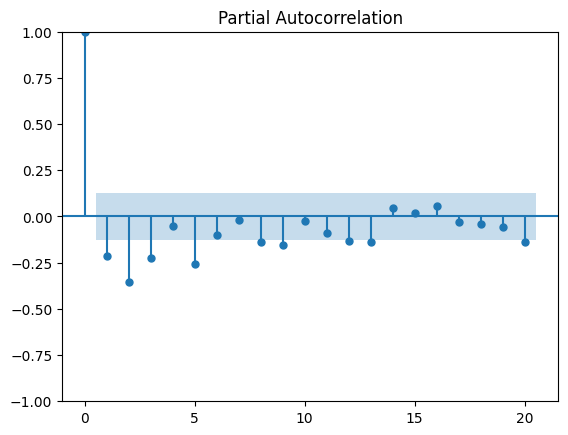

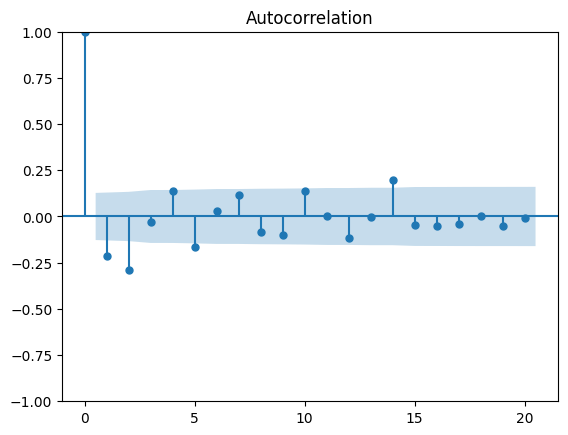

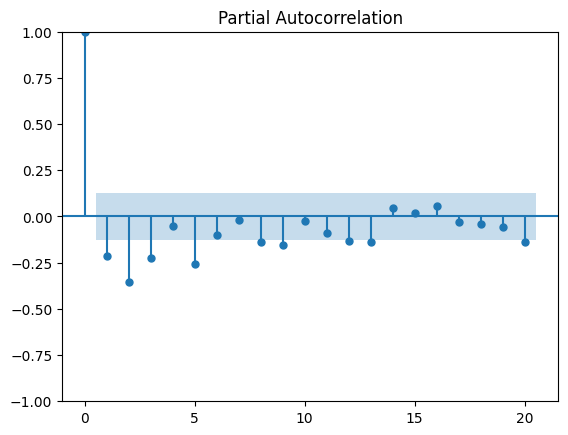

In [382]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(garch_residuals, order=(2,2,2))  # Adjust p (AR terms) and q (MA terms)
result = model.fit()

# Step 4: Check for seasonality or trends
from statsmodels.tsa.seasonal import seasonal_decompose
#decomposition = seasonal_decompose(residuals, model='additive', period=90)

new_residuals = result.resid

ljung_box_results = acorr_ljungbox(new_residuals, lags=[1, 2, 3, 4, 5], return_df=True)
print(ljung_box_results)

# Step 5: Re-run residual diagnostics

plot_acf(new_residuals, lags=20)
plot_pacf(new_residuals, lags=20)

In [94]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Initialize variables
window_size = 100  # Rolling window size (can be adjusted)
residuals = (har_data['rv'][100:] - har_predictions).values  # Residuals from HAR model (replace with actual residuals)
predictions = []
actuals = []

# Perform sliding window and model fitting
for i in range(window_size, len(residuals)):  # Loop from window_size to end of residuals
    # Train the ARIMA model on the rolling window (t-1 points)
    train_data = residuals[i-window_size:i]  # Residuals from t-window_size to t-1
    arima_model = ARIMA(train_data, order=(1,1,1))  # p, d, q should be chosen based on model selection criteria
    arima_model_fit = arima_model.fit()

    # Predict the next residual (at time t)
    prediction = arima_model_fit.forecast(steps=1)[0]
    predictions.append(prediction)

    # Actual residual at time t (ground truth)
    actuals.append(residuals[i])

# Calculate MSE between predictions and actuals
mse = mean_squared_error(actuals, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.1210335035224403


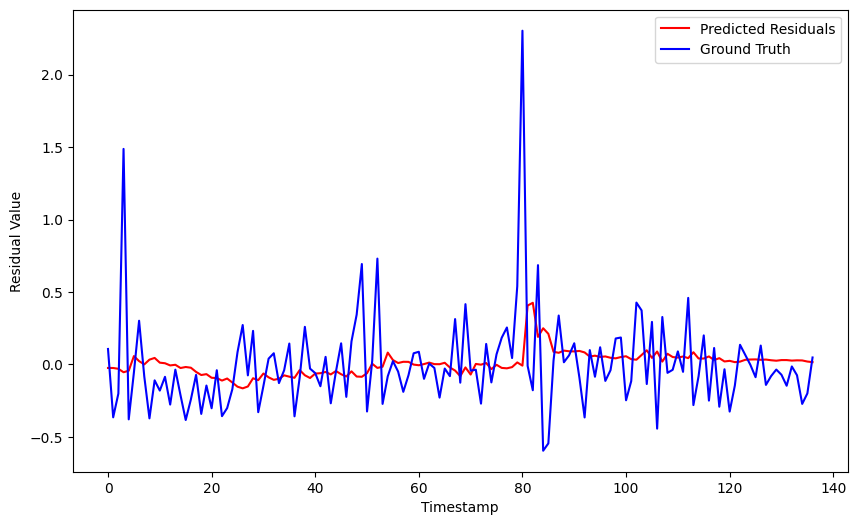

In [95]:
plt.figure(figsize=(10,6))
plt.plot(predictions, label='Predicted Residuals', color='red')
plt.plot(actuals, label='Ground Truth', color='blue')
plt.ylabel('Residual Value')
plt.xlabel('Timestamp')
plt.legend()